# IMPORTS

In [95]:
import pandas as pd
import random
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for cramer v
from scipy import stats as ss
#for univariate analysis
from pandas_profiling import ProfileReport
#preprocessing
from sklearn.preprocessing import FunctionTransformer, PowerTransformer,\
MaxAbsScaler, StandardScaler, RobustScaler, MinMaxScaler
# for under/over sampling
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c
# for feature selection
from boruta import BorutaPy
#for splitting data
from sklearn import model_selection as ms
#for metrics
from sklearn import metrics as m
from scikitplot import metrics as mt
#for ML
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models as ml
from tensorflow.keras import layers as l
from tensorflow.keras.callbacks import EarlyStopping
#for balancing data
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss

## Data

In [2]:
SEED=42

In [3]:
data = pd.read_csv('../PS_20174392719_1491204439457_log.csv')

In [4]:
data.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [5]:
data[['step','isFraud']].groupby('isFraud').count()

step
isFraud         
0        6354407
1           8213

In [6]:
# # para usar tudo
# df1=data.copy()

In [7]:
# para usar apenas parte dos dados
df1=data[data['type'].apply(lambda x: x in ['CASH_OUT', 'TRANSFER'])] #selecionar apenas cash out e transfer
df1=df1.groupby('isFraud').apply(lambda x: x.sample(frac=0.1))
df1=df1.reset_index(drop=True)

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', True )
    
    sns.set()

In [9]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\marcellohro\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Helper functions

In [10]:
def cross_validation( target, data2crossv, kfold, model_name, model, undersample=None):
    acc_list = []
    balanced_acc_list = []
    f1_list = []
    kappa_list = []
    
    kfold = ms.StratifiedKFold( n_splits=kfold, shuffle=True, random_state=SEED )
#     tscv = TimeSeriesSplit(n_splits=kfold)
    
    #data2crossv.set_index(['date'])
    X=data2crossv.drop(target,axis=1)
    Y=data2crossv[target]
    
    for train_index,test_index in kfold.split(X,Y):
        
        #splitting
        xtraining, xvalidation, ytraining, yvalidation = X.values[train_index], X.values[test_index], \
                                       Y.values[train_index], Y.values[test_index]
        
        if undersample:
            xtraining, ytraining = undersample.fit_sample(xtraining, ytraining)
                
        # model and prediction
        if model_name=='Neural Net':
            model.add( l.Dense( units=64, input_dim=xtraining.shape[1], activation='relu' ) )
            model.add( l.Dense( units=16, activation='relu') )
            model.add( l.Dense( units=1, activation='sigmoid') )
            model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
            model.fit( xtraining, ytraining, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[early_stop])
            yhat = model.predict_classes(xvalidation)
        else:
            m = model.fit( xtraining, ytraining.ravel() )
            yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, yvalidation, yhat)

        # store performance of each kfold iteration
        acc_list.append(  m_result['Accuracy'] )
        balanced_acc_list.append( m_result['Balanced accuracy'] )
        f1_list.append( m_result['F1 score'] )
        kappa_list.append( m_result['Kappa Metrics'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                          'ACC CV': np.round( np.mean( acc_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( acc_list ), 4 ).astype( str ),
                          'Balanced ACC CV': np.round( np.mean( balanced_acc_list ), 4).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list ), 4 ).astype( str ),
                          'F1 CV': np.round( np.mean( f1_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( f1_list ), 4 ).astype( str ),
                          'Kappa CV': np.round( np.mean( kappa_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_list ), 4 ).astype( str )
                         }, index=[0] )

In [11]:
def ml_error( model_name, y, yhat ):
    # Accuracy
    acc = m.accuracy_score( y, yhat )
    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y, yhat )
    # F1 score
    f1 = m.f1_score( y, yhat )
    # Kappa Metrics
    kappa = m.cohen_kappa_score( y, yhat )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'Accuracy': acc,
                           'Balanced accuracy': balanced_acc,
                           'F1 score': f1, 
                           'Kappa Metrics': kappa
                         }, index=[0] )

In [12]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [13]:
def mod_round(x):
    x=abs(x)
    x=round(x)
    return x

In [14]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    discrete = [var for var in data.columns if data[var].dtype != 'O' and data[var].nunique() < 35]
    continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype == 'O']

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    
    return discrete,continuous,categorical

# FEATURE ENGINEERING

In [15]:
df2=df1.copy()

## Cash Flow feature

In [16]:
# cash flow
df2['FlowOrig']=df2['newbalanceOrig']-df2['oldbalanceOrg']
df2['FlowDest']=df2['newbalanceDest']-df2['oldbalanceDest']

## Amount is different than cash flow flag feature

In [17]:
# flag if amount is different than cash flow
df2['amount_anomaly_orig']=(df2['FlowOrig']).apply(mod_round)!=df2['amount'].apply(mod_round)
df2['amount_anomaly_dest']=(df2['FlowDest']).apply(mod_round)!=df2['amount'].apply(mod_round)

## Inflow vs Outflow

In [18]:
df2['FluxOrig']=df2['FlowOrig'].apply(sign)
df2['FluxDest']=df2['FlowDest'].apply(sign)

## Anomaly flow

In [19]:
df2['disc_orig_amount']=abs(df2['newbalanceOrig']-df2['oldbalanceOrg'])-df2['amount']
df2['disc_dest_amount']=abs(df2['newbalanceDest']-df2['oldbalanceDest'])-df2['amount']

## Name Char feature

In [20]:
# name origin engineering mixed type variable
df2['nameOrig_char']=df2['nameOrig'].str[0] # captures the first letter
df2['nameOrig_num']=df2['nameOrig'].str.extract('(\d+)') # captures numerical part

In [21]:
# name destination engineering mixed type variable
df2['nameDest_char']=df2['nameDest'].str[0] # captures the first letter
df2['nameDest_num']=df2['nameDest'].str.extract('(\d+)') # captures numerical part

In [22]:
# nameOrig_char contains no information
df2['nameOrig_char'].unique()

array(['C'], dtype=object)

In [23]:
df2['nameDest_char'].unique()

array(['C'], dtype=object)

In [24]:
# if first char is M thare is actually no anomaly
df2.loc[df2['nameDest_char']=='M',['amount_anomaly_dest']]=False

## Drop redundancy

'nameOrig','nameDest','nameOrig_char'

In [25]:
#drop redundant columns
df2.drop(labels=['nameOrig','nameDest','nameOrig_char'],axis=1,inplace=True)

## Number of transactions features

In [26]:
count_map = df2['nameDest_num'].value_counts().to_dict()
df2['num_of_transactions_dest']=df2['nameDest_num'].map(count_map)
# df2.sample(2)

In [27]:
count_map = df2['nameOrig_num'].value_counts().to_dict()
df2['num_of_transactions_orig']=df2['nameOrig_num'].map(count_map)
# df2.sample(2)

## Drop redundancy

'nameOrig_num','nameDest_num'

In [28]:
# Deletar colunas de numero de conta
df2.drop(['nameOrig_num','nameDest_num'],axis=1,inplace=True)

## Day and hour features

In [29]:
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

In [30]:
df2['hour']=df2['day']*24-df2['step']

## Inflow/outflow features

In [31]:
#Essa variavel deveria mostrar se o fluxo esta certo (-1 significa entrando de uma fonte e saindo da outra)
df2['Flux']=df2['FluxOrig']*df2['FluxDest']

## drop redundancy

'step','isFlaggedFraud','FlowOrig','FlowDest','nameDest_char','Flux'

In [32]:
df3=df2.copy()

In [33]:
df3.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'FlowOrig', 'FlowDest', 'amount_anomaly_orig', 'amount_anomaly_dest',
       'FluxOrig', 'FluxDest', 'disc_orig_amount', 'disc_dest_amount',
       'nameDest_char', 'num_of_transactions_dest', 'num_of_transactions_orig',
       'day', 'hour', 'Flux'],
      dtype='object')

In [34]:
# #manual selection
# df4=df3.drop(['step','amount','isFlaggedFraud','Flux','newbalanceOrig',\
#          'newbalanceDest','nameDest_char'],axis=1)

In [35]:
#manual selection
df3=df3.drop(['step','isFlaggedFraud','FlowOrig','FlowDest',\
         'nameDest_char','Flux'],axis=1)

# DATA BALANCE

**Analysis**
* near-miss 1,2 and 3 removes outliers from class no-fraud and can balance 1:1
* OneSidedSelection is more theoritically consistent but can balance only around 10:1
* NeighbourhoodCleaningRule and tomeklinks is bad at balancing, but good at redundant data
* Maybe combining algorithims that can't balance 1:1 with random undersamper?
* Better test every undersampler with gridsearch pipeline

# DATA PREPARATION

In [36]:
df4=df3.copy()

## Categorical variables

In [37]:
discrete,continuous,categorical=variable_types(df4)

There are 9 discrete variables
There are 7 continuous variables
There are 1 categorical variables


In [38]:
df4[categorical] = pd.get_dummies(df4[categorical],drop_first=True)

In [39]:
df4[categorical].sample(3)

type
142602     0
144536     0
227898     0

## Outlier capping and log-scale preparation

In [40]:
df4ol=df4.copy()

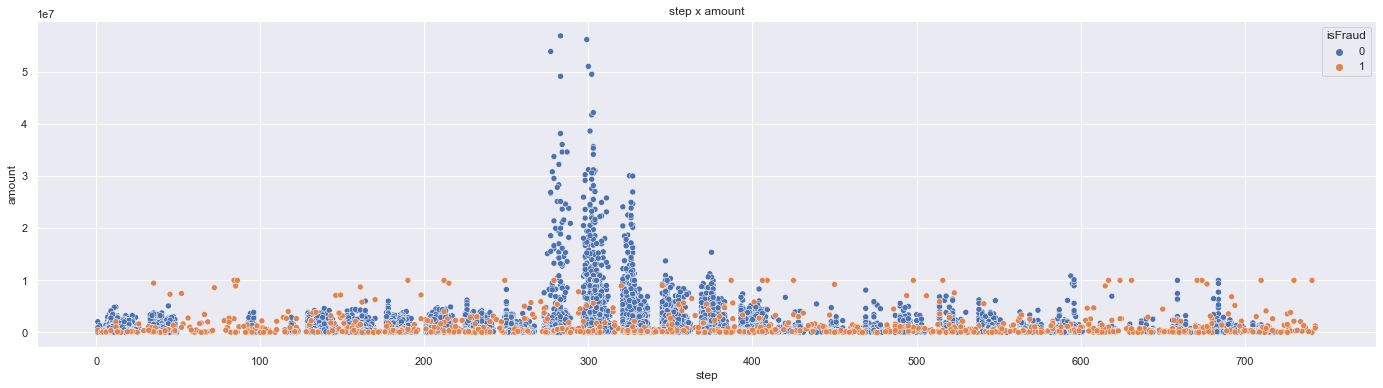

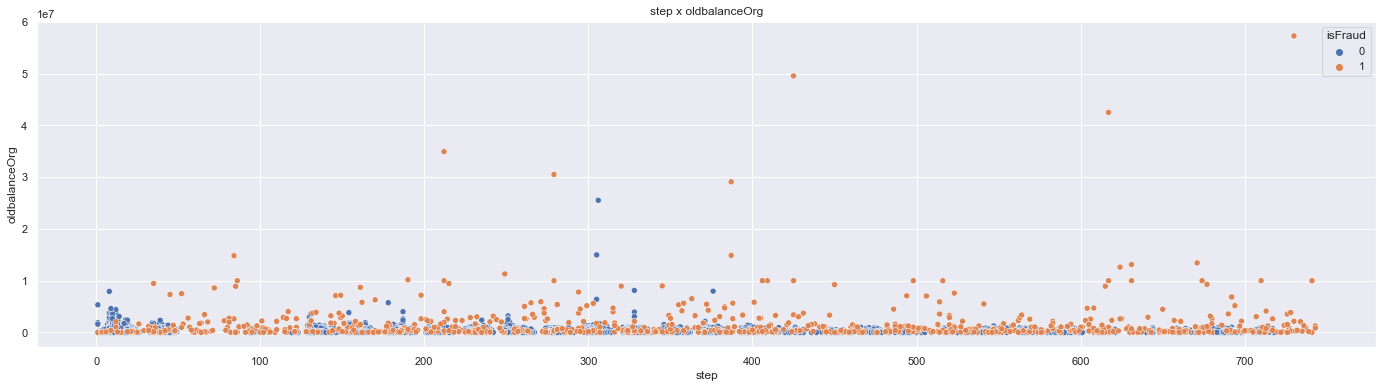

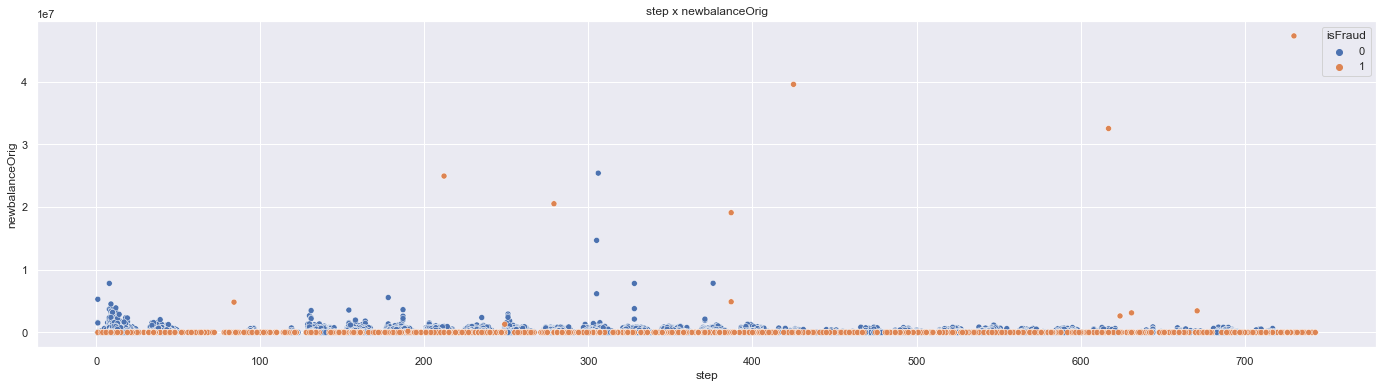

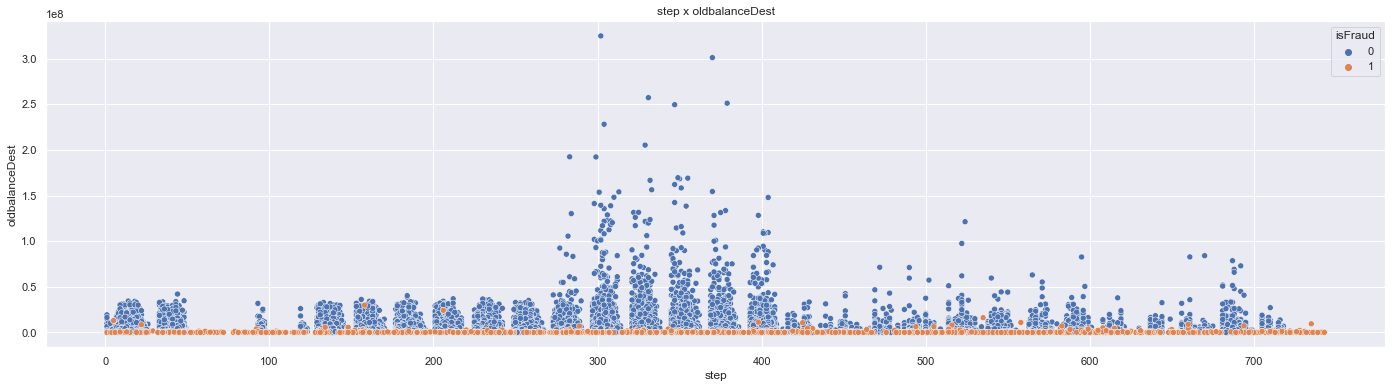

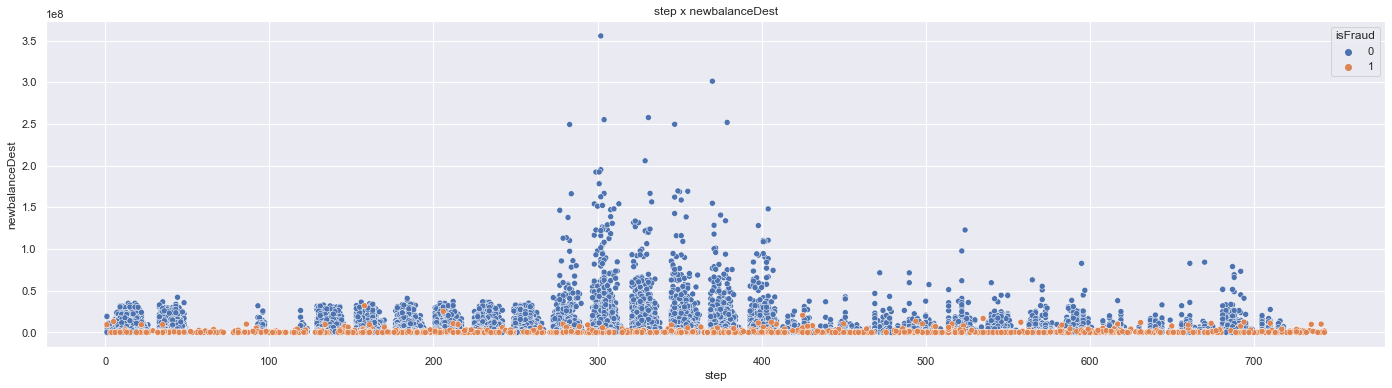

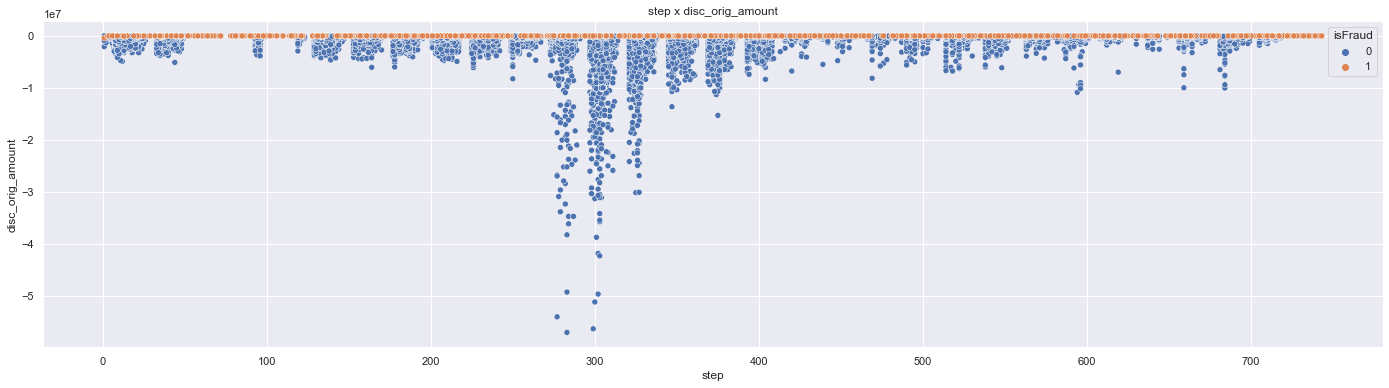

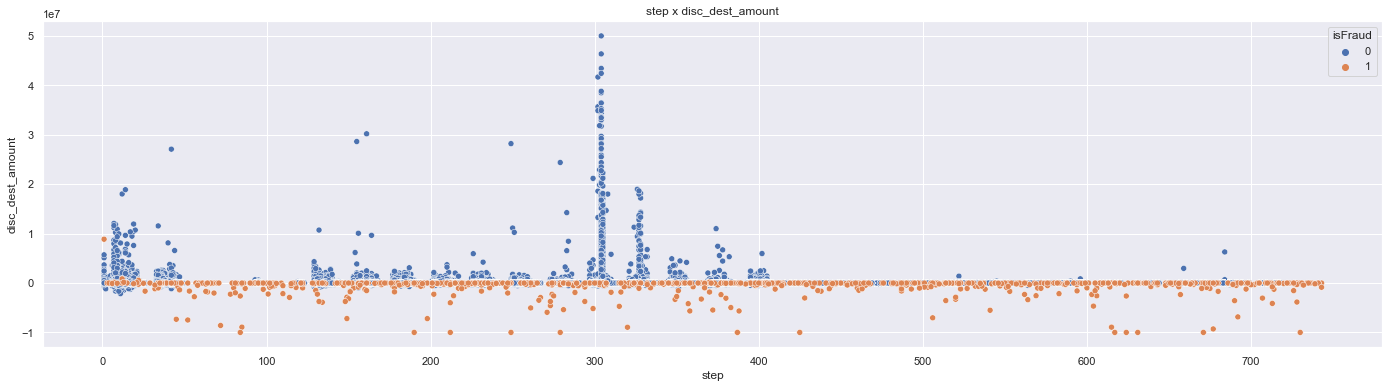

In [41]:
aux=df4.copy()
aux=pd.concat([aux,df1['step']],axis=1)
for var in continuous:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='step', y=var, hue='isFraud', data=aux)
    plt.ylabel(var)
    plt.title('step x ' + var)
    plt.show()

In [42]:
#multiplicar disc_orig_amount por -1 para facilitar transformação em logscale
df4ol['disc_orig_amount']=-df4ol['disc_orig_amount']

In [43]:
df4ol[continuous].max()

amount              5.695142e+07
oldbalanceOrg       5.731626e+07
newbalanceOrig      4.731626e+07
oldbalanceDest      3.249151e+08
newbalanceDest      3.555534e+08
disc_orig_amount    5.695142e+07
disc_dest_amount    5.003383e+07
dtype: float64

In [44]:
df4ol[continuous].min()

amount                     0.00
oldbalanceOrg              0.00
newbalanceOrig             0.00
oldbalanceDest             0.00
newbalanceDest             0.00
disc_orig_amount          -0.01
disc_dest_amount   -10000000.00
dtype: float64

In [45]:
df4ol['flag_outlier']=(df4ol['amount']>1.5e7) | (df4ol['oldbalanceDest']>3e7) | (df4ol['newbalanceDest']>3e7)

In [46]:
#capping positive values
amount_ol=1.5e7
oldbalancedest_ol=3e7
newbalancedest_ol=3e7
df4ol.loc[df4ol['amount']>amount_ol,['amount']]=amount_ol
df4ol.loc[df4ol['oldbalanceDest']>oldbalancedest_ol,['oldbalanceDest']]=oldbalancedest_ol
df4ol.loc[df4ol['newbalanceDest']>newbalancedest_ol,['newbalanceDest']]=newbalancedest_ol

In [47]:
#capping negative values
disc_dest_amount_ol=-1e7
disc_orig_amount_ol=0
df4ol.loc[df4ol['disc_dest_amount']<disc_dest_amount_ol,['disc_dest_amount']]=disc_dest_amount_ol
df4ol.loc[df4ol['disc_orig_amount']<disc_orig_amount_ol,['disc_orig_amount']]=disc_orig_amount_ol

## Continuous variables

### log1p-scaling

In [48]:
df5=df4ol.copy()

In [49]:
discrete,continuous,categorical=variable_types(df5)

There are 11 discrete variables
There are 7 continuous variables
There are 0 categorical variables


#### data preparation for log scaling

In [50]:
df5[continuous].min()

amount                     0.0
oldbalanceOrg              0.0
newbalanceOrig             0.0
oldbalanceDest             0.0
newbalanceDest             0.0
disc_orig_amount          -0.0
disc_dest_amount   -10000000.0
dtype: float64

In [51]:
#add constant to bring negative values to 0
df5['disc_dest_amount']+=1e7

In [52]:
df5[continuous].min()

amount              0.0
oldbalanceOrg       0.0
newbalanceOrig      0.0
oldbalanceDest      0.0
newbalanceDest      0.0
disc_orig_amount   -0.0
disc_dest_amount    0.0
dtype: float64

#### transformation

In [53]:
aux=df5.copy()
cols=continuous
transformer = FunctionTransformer(np.log1p, validate=True)
transformer.fit(aux[cols].fillna(1))
data_t = transformer.transform(aux[cols].fillna(1))
data_t = pd.DataFrame(data_t, columns = cols)
# for var in cols:
#     diagnostic_plots(data_t, var)

In [54]:
cont_data=data_t.copy()
aux=data_t.copy()
aux=pd.concat([aux,df5[['day','isFraud']]],axis=1)

-0.7102853789329888


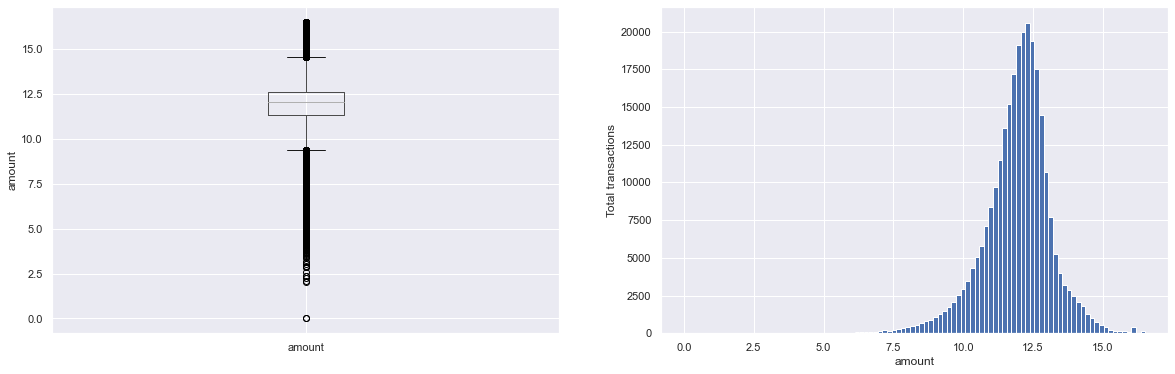

0.09391833548458185


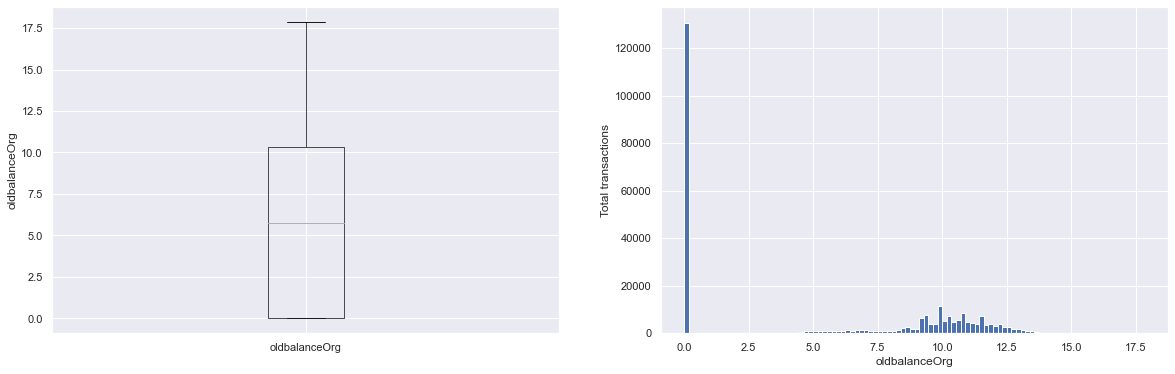

2.785078396366313


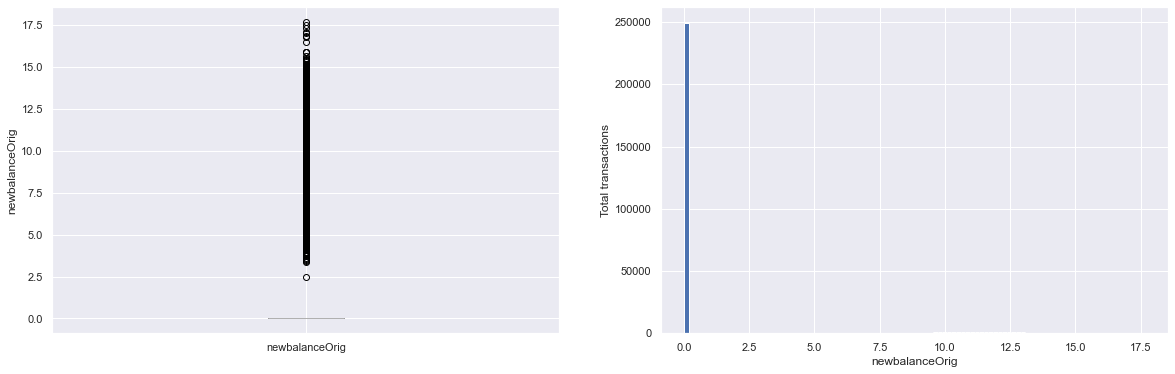

-1.6998753792870454


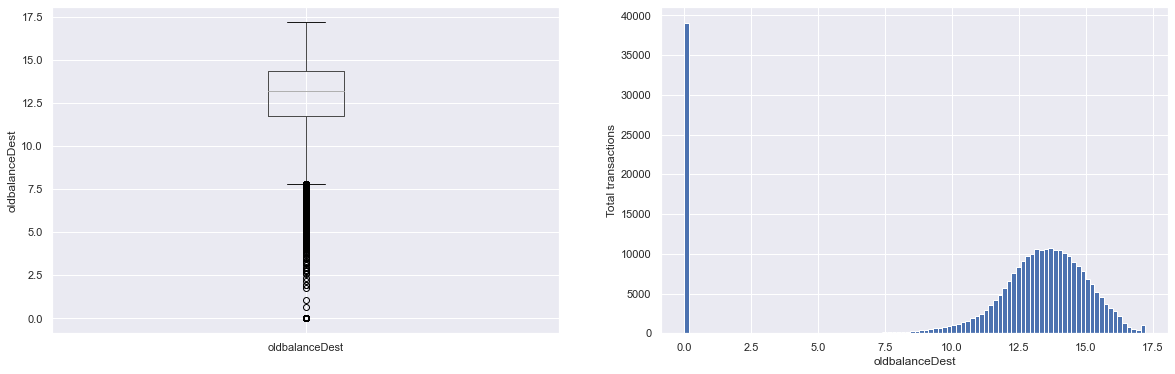

-2.8399232772302714


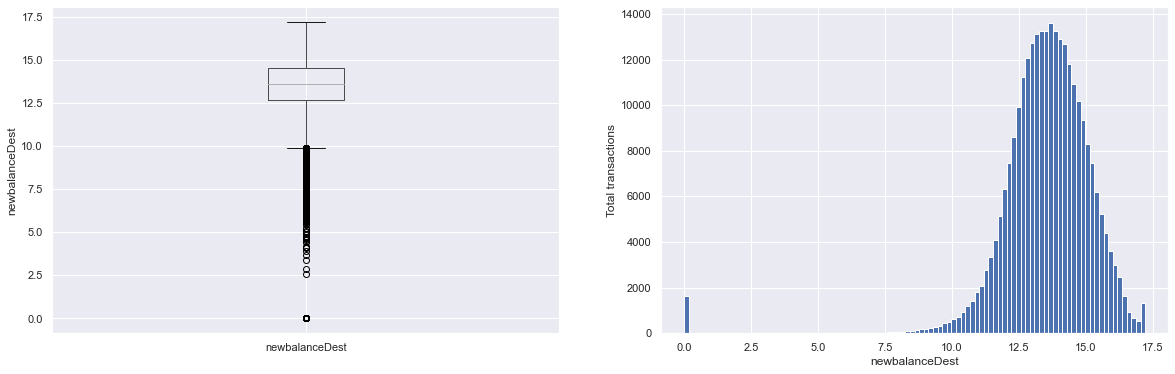

-2.17642508671834


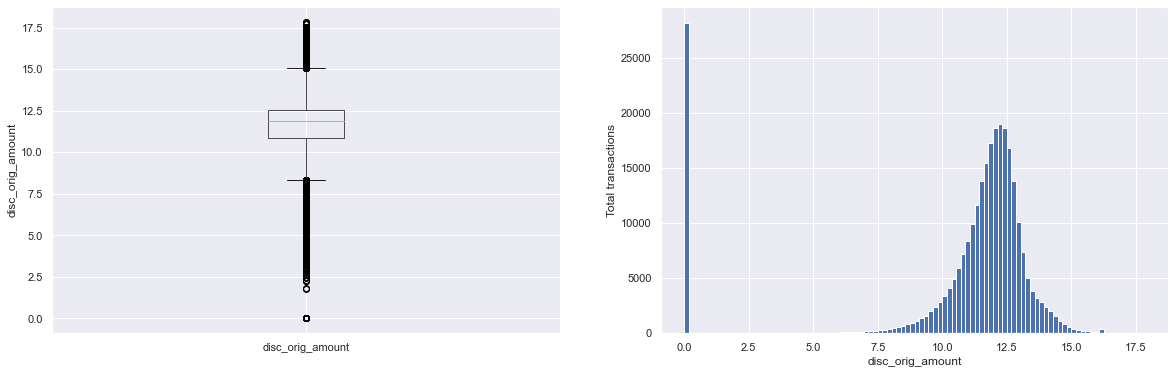

-126.44872957661993


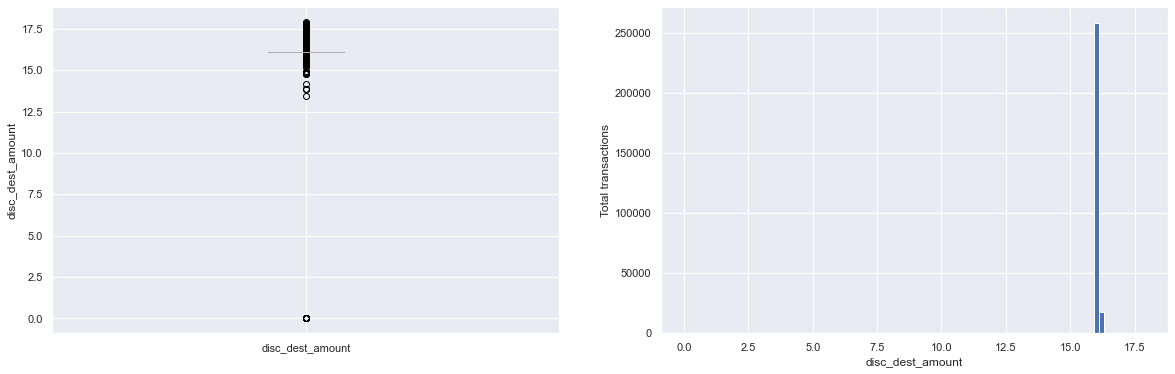

In [55]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution
# aux=df4.copy()
for var in continuous:
    print(aux[var].skew())
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    fig = aux.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = aux[var].hist(bins=100)
    fig.set_ylabel('Total transactions')
    fig.set_xlabel(var)

    plt.show()

In [56]:
cont_data

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0       12.722033       0.000000             0.0       14.425510   
1       12.131565       0.000000             0.0       16.265947   
2       12.012690       9.658034             0.0       14.077841   
3       12.318044       0.000000             0.0       14.199877   
4       12.896011       0.000000             0.0       13.503385   
...           ...            ...             ...             ...   
277036  12.260499      12.260499             0.0       10.973090   
277037  14.625812      14.625812             0.0        0.000000   
277038  12.798185      12.798185             0.0       13.131657   
277039  14.654032      14.654032             0.0        0.000000   
277040  14.024161      14.024161             0.0        0.000000   

        newbalanceDest  disc_orig_amount  disc_dest_amount  
0            14.592760         12.722033         16.118096  
1            16.281833         12.131565         16.118096  
2            14.197221         11.912957         16.118096  
3            14.341645         12.318044         16.118096  
4            13.938265         12.896011         16.118096  
...                ...               ...               ...  
277036       12.504214         -0.000000         16.118096  
277037        0.000000         -0.000000         15.863386  
277038       12.151839         -0.000000         16.113452  
277039       14.654032         -0.000000         16.118096  
277040        0.000000         -0.000000         15.986618  

[277041 rows x 7 columns]

In [57]:
cont_data.describe()

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  277041.000000  277041.000000   277041.000000   277041.000000   
mean       11.926863       5.278828        1.096387       11.552174   
std         1.230716       5.207471        3.344566        4.912978   
min         0.000000       0.000000        0.000000        0.000000   
25%        11.328324       0.000000        0.000000       11.754722   
50%        12.052991       5.723585        0.000000       13.226581   
75%        12.633371      10.341452        0.000000       14.368521   
max        16.523561      17.864095       17.672364       17.216708   

       newbalanceDest  disc_orig_amount  disc_dest_amount  
count   277041.000000     277041.000000     277041.000000  
mean        13.534802         10.680641         16.119913  
std          1.747272          3.790338          0.115723  
min          0.000000          0.000000          0.000000  
25%         12.697004         10.853405         16.118096  
50%         13.625089         11.876684         16.118096  
75%         14.569969         12.541427         16.118096  
max         17.216708         17.857709         17.910419

## Discrete variables

In [58]:
disc_data=df5[discrete].drop(['isFraud','flag_outlier'],axis=1)

In [59]:
disc_data.sample(10)

type  amount_anomaly_orig  amount_anomaly_dest  FluxOrig  FluxDest  \
241490     1                False                False      -1.0       1.0   
198422     0                 True                False      -1.0       1.0   
108771     1                 True                False       0.0       1.0   
237257     1                 True                False      -1.0       1.0   
34296      0                 True                 True       0.0       1.0   
106782     1                 True                False       0.0       1.0   
225399     0                 True                False       0.0       1.0   
73436      0                 True                False      -1.0       1.0   
40323      1                 True                False       0.0       1.0   
52023      0                 True                False       0.0       1.0   

        num_of_transactions_dest  num_of_transactions_orig  day  hour  
241490                         1                         1    8     4  
198422                         1                         1   13    13  
108771                         1                         1   14    15  
237257                         4                         1    1    16  
34296                          4                         1    1    15  
106782                         2                         1    6    10  
225399                         1                         1   10    12  
73436                          3                         1    1     9  
40323                          3                         1    7    10  
52023                          2                         1   15    14

### Cyclic transformation of time

In [60]:
disc_data.day.unique()

array([12,  9, 11,  7, 29,  2, 17, 14, 13, 16,  8,  6, 10,  1, 25, 30,  4,
       24, 15, 23, 18,  5, 26, 28, 21, 22, 20, 19, 27,  3, 31],
      dtype=int64)

In [61]:
disc_data['day']-=1

In [62]:
def cyclic_transf(s):
    norm = 2*math.pi*s/s.max()
    cos = np.cos(norm)
    sin = np.sin(norm)
    return cos,sin

In [63]:
disc_data['day_cos'],disc_data['day_sin']=cyclic_transf(disc_data['day'])

In [64]:
disc_data.hour.unique()

array([ 9,  6,  5,  2,  7, 11, 13,  8,  4, 12,  3, 14, 10,  0, 15,  1, 16,
       23, 17, 22, 18, 21, 20, 19], dtype=int64)

In [65]:
disc_data['hour_cos'],disc_data['hour_sin']=cyclic_transf(disc_data['hour'])

In [66]:
disc_data.drop(['day','hour'],axis=1,inplace=True)

In [67]:
disc_data.sample(5)

type  amount_anomaly_orig  amount_anomaly_dest  FluxOrig  FluxDest  \
72681      0                 True                False       0.0       1.0   
147225     0                 True                False       0.0       1.0   
247451     0                 True                False       0.0       1.0   
203296     1                 True                False       0.0       1.0   
189583     0                 True                False       0.0       1.0   

        num_of_transactions_dest  num_of_transactions_orig   day_cos  \
72681                          1                         1  0.309017   
147225                         2                         1  0.309017   
247451                         1                         1  0.309017   
203296                         2                         1 -0.309017   
189583                         2                         1 -0.309017   

         day_sin  hour_cos  hour_sin  
72681  -0.951057 -0.990686  0.136167  
147225  0.951057 -0.576680 -0.816970  
247451  0.951057  0.460065  0.887885  
203296 -0.951057 -0.068242  0.997669  
189583  0.951057  0.203456  0.979084

## rescale variables

In [68]:
(cont_data.max() - cont_data.min())

amount              16.523561
oldbalanceOrg       17.864095
newbalanceOrig      17.672364
oldbalanceDest      17.216708
newbalanceDest      17.216708
disc_orig_amount    17.857709
disc_dest_amount    17.910419
dtype: float64

In [69]:
cont_data_r=cont_data/20 #rescale continuous variables

In [70]:
(cont_data_r.max() - cont_data_r.min())

amount              0.826178
oldbalanceOrg       0.893205
newbalanceOrig      0.883618
oldbalanceDest      0.860835
newbalanceDest      0.860835
disc_orig_amount    0.892885
disc_dest_amount    0.895521
dtype: float64

In [71]:
disc_data.dtypes

type                          uint8
amount_anomaly_orig            bool
amount_anomaly_dest            bool
FluxOrig                    float64
FluxDest                    float64
num_of_transactions_dest      int64
num_of_transactions_orig      int64
day_cos                     float64
day_sin                     float64
hour_cos                    float64
hour_sin                    float64
dtype: object

In [72]:
disc_data[['type','amount_anomaly_orig','amount_anomaly_dest']]=disc_data[['type','amount_anomaly_orig','amount_anomaly_dest']].astype(int)

In [73]:
disc_data.max()

type                         1.000000
amount_anomaly_orig          1.000000
amount_anomaly_dest          1.000000
FluxOrig                     0.000000
FluxDest                     1.000000
num_of_transactions_dest    14.000000
num_of_transactions_orig     2.000000
day_cos                      1.000000
day_sin                      0.994522
hour_cos                     1.000000
hour_sin                     0.997669
dtype: float64

In [74]:
disc_data.max()

type                         1.000000
amount_anomaly_orig          1.000000
amount_anomaly_dest          1.000000
FluxOrig                     0.000000
FluxDest                     1.000000
num_of_transactions_dest    14.000000
num_of_transactions_orig     2.000000
day_cos                      1.000000
day_sin                      0.994522
hour_cos                     1.000000
hour_sin                     0.997669
dtype: float64

In [75]:
#rescale discrete variables
disc_data_r=disc_data.copy()
disc_data_r[['num_of_transactions_orig','FluxOrig','FluxDest','day_cos','day_sin','hour_cos','hour_sin']]/=2
disc_data_r[['num_of_transactions_dest']]/=15

In [76]:
(disc_data_r.max() - disc_data_r.min())

type                        1.000000
amount_anomaly_orig         1.000000
amount_anomaly_dest         1.000000
FluxOrig                    0.500000
FluxDest                    1.000000
num_of_transactions_dest    0.866667
num_of_transactions_orig    0.500000
day_cos                     1.000000
day_sin                     0.994522
hour_cos                    0.995343
hour_sin                    0.997669
dtype: float64

# FEATURE SELECTION

**Analysis**

* Boruta and DecisionTreeClassifier are consistent without undersampling and not consistent with undersampling

**Boruta columns selected without undersampling:**  ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'disc_orig_amount', 'disc_dest_amount', 'type', 'amount_anomaly_orig', 'FluxDest']

**Boruta columns selected with undersampling:**  ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'disc_orig_amount', 'disc_dest_amount']

* time features are not important
* number of transactions is not important!
* Direction of money flow on origin is not important, but on destination is

**to be conservative use columns selected without undersampling**

In [77]:
df6=pd.concat([cont_data_r,disc_data_r,df5['isFraud']],axis=1)

## Balancing data for feature importance algorithms

Since ML will be trained on balanced data, data should also be balanced for feature selection step


In [78]:
# X and y for feature importance testing
X = df6.drop(['isFraud'],axis=1).values
y = df6['isFraud'].values.ravel()

In [79]:
undersample = OneSidedSelection(sampling_strategy='majority', n_neighbors=1, n_seeds_S=5000, random_state=SEED)
X, y = undersample.fit_sample(X, y)
# df4us=pd.concat([X_tl,y_tl],axis=1)

## Decision tree feature importance

In [80]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

<AxesSubplot:>

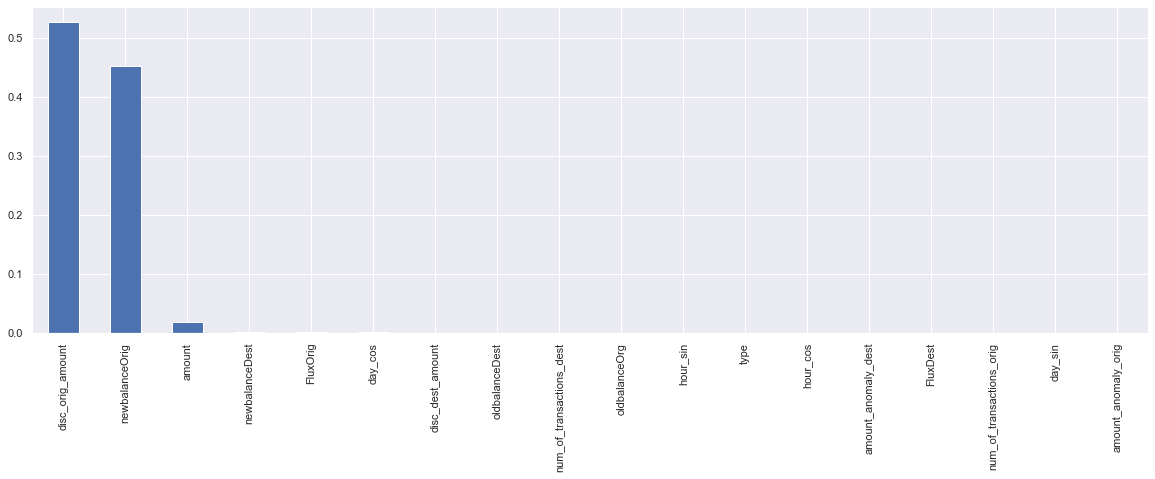

In [81]:
# summarize feature importance
importance=pd.Series(importance)
importance.index = df6.drop(['isFraud'],axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,6))

In [82]:
importance

disc_orig_amount            0.525566
newbalanceOrig              0.452313
amount                      0.017898
newbalanceDest              0.001431
FluxOrig                    0.001232
day_cos                     0.001174
disc_dest_amount            0.000233
oldbalanceDest              0.000145
num_of_transactions_dest    0.000007
oldbalanceOrg               0.000000
hour_sin                    0.000000
type                        0.000000
hour_cos                    0.000000
amount_anomaly_dest         0.000000
FluxDest                    0.000000
num_of_transactions_orig    0.000000
day_sin                     0.000000
amount_anomaly_orig         0.000000
dtype: float64

## Boruta feature importance

In [ ]:
# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators=1000, verbose=2, random_state=SEED ).fit( X, y )

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_fs = df6.drop(['isFraud'],axis=1)
cols_selected_boruta = X_fs.iloc[:, cols_selected].columns.to_list()
print('cols selected: ',cols_selected_boruta)
print('')
# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_fs.columns, cols_selected_boruta ) )
print('cols not selected: ',cols_not_selected_boruta)

# MACHINE LEARNING

**model selected**: Random forest without balancing

**Boruta columns selected without undersampling:**  ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'disc_orig_amount', 'disc_dest_amount', 'type', 'amount_anomaly_orig', 'FluxDest']

In [84]:
cols_selected_boruta = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'disc_orig_amount', 'disc_dest_amount', 'type', 'amount_anomaly_orig', 'FluxDest']

In [85]:
df7=pd.concat([df6[cols_selected_boruta],df6['isFraud']],axis=1)

In [86]:
df7.tail(3)

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
277038  0.639909       0.639909             0.0        0.656583   
277039  0.732702       0.732702             0.0        0.000000   
277040  0.701208       0.701208             0.0        0.000000   

        newbalanceDest  disc_orig_amount  disc_dest_amount  type  \
277038        0.607592              -0.0          0.805673     0   
277039        0.732702              -0.0          0.805905     0   
277040        0.000000              -0.0          0.799331     1   

        amount_anomaly_orig  FluxDest  isFraud  
277038                    0      -0.5        1  
277039                    0       0.5        1  
277040                    0       0.0        1

In [87]:
target=['isFraud']

## Baseline
random choice

In [182]:
# Split dataset into training and test
X=df7.drop(['isFraud'],axis=1)
y=df7['isFraud']
x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

In [183]:
frauds_weights=df7['isFraud'].value_counts( normalize=True ).sort_index().tolist()
k_num = y_test.shape[0]
yhat_random = random.choices( population=[0, 1],  
                              weights=frauds_weights,
                              k=k_num )

  Model Name  Accuracy  Balanced accuracy  F1 score  Kappa Metrics
0     random  0.994351           0.502048  0.006349       0.003565 



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

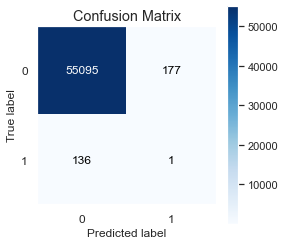

In [184]:
print( ml_error('random',y_test,yhat_random), '\n' )

# # Classification report
# print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(4,4))

## Testing ML algorithms

### No undersampling
winner: 0.9963 +/- 0.0023 randomforest

In [215]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN3_cv = cross_validation( target, df7, 5, 'KNN-3', KNN)
KNN3_cv

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN5_cv = cross_validation( target, df7, 5, 'KNN-5', KNN
KNN5_cv

In [188]:
KNN = KNeighborsClassifier(n_neighbors=10)
KNN10_cv = cross_validation( target, df7, 5, 'KNN-10', KNN)
KNN10_cv

Model Name          ACC CV    Balanced ACC CV              F1 CV  \
0     KNN-10  0.9999 +/- 0.0  0.9902 +/- 0.0052  0.9865 +/- 0.0063   

            Kappa CV  
0  0.9865 +/- 0.0063

In [216]:
lg = LogisticRegression()
lg_cv = cross_validation( target, df7, 5, 'Logistic Regression', lg)
lg_cv

Model Name             ACC CV    Balanced ACC CV  \
0  Logistic Regression  0.9999 +/- 0.0001  0.9884 +/- 0.0101   

              F1 CV           Kappa CV  
0  0.987 +/- 0.0101  0.9869 +/- 0.0101

In [192]:
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df7, 5, 'Decision Tree', dtc)
dtc_cv

Model Name          ACC CV    Balanced ACC CV              F1 CV  \
0  Decision Tree  0.9999 +/- 0.0  0.9951 +/- 0.0024  0.9903 +/- 0.0049   

            Kappa CV  
0  0.9902 +/- 0.0049

In [194]:
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df7, 5, 'Random Forest', rfc)
rfc_cv

Model Name       ACC CV    Balanced ACC CV              F1 CV  \
0  Random Forest  1.0 +/- 0.0  0.9963 +/- 0.0023  0.9963 +/- 0.0023   

            Kappa CV  
0  0.9963 +/- 0.0023

In [196]:
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df7, 5, 'XGBoost', xgbc)
xgbc_cv

Model Name       ACC CV    Balanced ACC CV              F1 CV  \
0    XGBoost  1.0 +/- 0.0  0.9963 +/- 0.0023  0.9945 +/- 0.0052   

            Kappa CV  
0  0.9945 +/- 0.0052

In [198]:
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df7, 5, 'SVM_linear', svm)
svm_cv_l

Model Name          ACC CV    Balanced ACC CV              F1 CV  \
0  SVM_linear  0.9999 +/- 0.0  0.9927 +/- 0.0103  0.9889 +/- 0.0086   

            Kappa CV  
0  0.9889 +/- 0.0087

In [199]:
svm = SVC()
svm_cv_rbf = cross_validation( target, df7, 5, 'SVM_rbf', svm)
svm_cv_rbf

Model Name       ACC CV    Balanced ACC CV              F1 CV  \
0    SVM_rbf  1.0 +/- 0.0  0.9957 +/- 0.0031  0.9933 +/- 0.0013   

            Kappa CV  
0  0.9933 +/- 0.0013

In [200]:
model = ml.Sequential()
NN_cv = cross_validation( target, df7, 5, 'Neural Net', model)
NN_cv

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 221632 samples, validate on 55409 samples
Epoch 1/20
221632/221632 [==============================] - 9s 41us/sample - loss: 0.0059 - acc: 0.9980 - val_loss: 7.3922e-05 - val_acc: 1.0000
Epoch 2/20
221632/221632 [==============================] - 8s 36us/sample - loss: 3.3498e-04 - acc: 1.0000 - val_loss: 6.5702e-05 - val_acc: 1.0000
Epoch 3/20
221632/221632 [==============================] - 8s 36us/sample - loss: 2.9680e-04 - acc: 1.0000 - val_loss: 6.0254e-06 - val_acc: 1.0000
Epoch 4/20
221632/221632 [==============================] - 8s 36us/sample - loss: 2.3354e-04 - acc: 1.0000 - val_loss: 9.9055e-04 - val_acc: 0.9994
Epoch 5/20
221632/221632 [==============================] - 8s 36us/sample - loss: 2.1193e-04 - acc: 1.0000 - val_loss: 1.5067e-06 - val_acc: 1.0

Model Name       ACC CV    Balanced ACC CV              F1 CV  \
0  Neural Net  1.0 +/- 0.0  0.9963 +/- 0.0036  0.9951 +/- 0.0031   

            Kappa CV  
0  0.9951 +/- 0.0031

In [201]:
# Without balancing and boruta filtering
#winner: 0.9963 +/- 0.0023 randomforest
modelling_result_cv = pd.concat( [
    KNN3_cv,
    KNN5_cv,
    KNN10_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

Model Name             ACC CV    Balanced ACC CV  \
0               KNN-10     0.9999 +/- 0.0  0.9902 +/- 0.0052   
0  Logistic Regression  0.9999 +/- 0.0001  0.9884 +/- 0.0101   
0        Decision Tree     0.9999 +/- 0.0  0.9951 +/- 0.0024   
0        Random Forest        1.0 +/- 0.0  0.9963 +/- 0.0023   
0              XGBoost        1.0 +/- 0.0  0.9963 +/- 0.0023   
0           SVM_linear     0.9999 +/- 0.0  0.9927 +/- 0.0103   
0              SVM_rbf        1.0 +/- 0.0  0.9957 +/- 0.0031   
0           Neural Net        1.0 +/- 0.0  0.9963 +/- 0.0036   

               F1 CV           Kappa CV  
0  0.9865 +/- 0.0063  0.9865 +/- 0.0063  
0   0.987 +/- 0.0101  0.9869 +/- 0.0101  
0  0.9903 +/- 0.0049  0.9902 +/- 0.0049  
0  0.9963 +/- 0.0023  0.9963 +/- 0.0023  
0  0.9945 +/- 0.0052  0.9945 +/- 0.0052  
0  0.9889 +/- 0.0086  0.9889 +/- 0.0087  
0  0.9933 +/- 0.0013  0.9933 +/- 0.0013  
0  0.9951 +/- 0.0031  0.9951 +/- 0.0031

### Undersampling with OneSidedSelection (Tomeklink+cnn) 
winner: 0.9969 +/- 0.0028 xgboost

obs: undersample is conducted during cross-validation, not before.

**Boruta columns selected with undersampling:**  ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'disc_orig_amount', 'disc_dest_amount']

In [89]:
cols_selected_boruta=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'disc_orig_amount', 'disc_dest_amount']

In [90]:
df8=pd.concat([df6[cols_selected_boruta],df6['isFraud']],axis=1)

In [224]:
undersample = OneSidedSelection(sampling_strategy='majority', n_neighbors=1, n_seeds_S=5000, random_state=SEED)

In [229]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN3_cv = cross_validation( target, df8, 5, 'KNN-3', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN5_cv = cross_validation( target, df8, 5, 'KNN-5', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=10)
KNN10_cv = cross_validation( target, df8, 5, 'KNN-10', KNN, undersample=undersample)
lg = LogisticRegression()
lg_cv = cross_validation( target, df8, 5, 'Logistic Regression', lg, undersample=undersample)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df8, 5, 'Decision Tree', dtc, undersample=undersample)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df8, 5, 'Random Forest', rfc, undersample=undersample)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df8, 5, 'XGBoost', xgbc, undersample=undersample)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df8, 5, 'SVM_linear', svm, undersample=undersample)
svm = SVC()
svm_cv_rbf = cross_validation( target, df8, 5, 'SVM_rbf', svm, undersample=undersample)

In [233]:
model = ml.Sequential()
NN_cv = cross_validation( target, df7, 5, 'Neural Net', model, undersample=undersample)

Train on 5802 samples, validate on 55409 samples
Epoch 1/20
5802/5802 [==============================] - 2s 287us/sample - loss: 0.1624 - acc: 0.9342 - val_loss: 0.0166 - val_acc: 0.9999
Epoch 2/20
5802/5802 [==============================] - 2s 260us/sample - loss: 0.0297 - acc: 0.9964 - val_loss: 0.0050 - val_acc: 0.9999
Epoch 3/20
5802/5802 [==============================] - 2s 267us/sample - loss: 0.0148 - acc: 0.9978 - val_loss: 0.0018 - val_acc: 0.9999
Epoch 4/20
5802/5802 [==============================] - 2s 259us/sample - loss: 0.0119 - acc: 0.9979 - val_loss: 0.0017 - val_acc: 0.9999
Epoch 5/20
5802/5802 [==============================] - 2s 266us/sample - loss: 0.0109 - acc: 0.9981 - val_loss: 0.0013 - val_acc: 0.9999
Epoch 6/20
5802/5802 [==============================] - 1s 257us/sample - loss: 0.0098 - acc: 0.9979 - val_loss: 7.2800e-04 - val_acc: 1.0000
Epoch 7/20
5802/5802 [==============================] - 2s 265us/sample - loss: 0.0094 - acc: 0.9981 - val_loss: 5.6464

In [234]:
# Without balancing and boruta filtering
#winner: 0.9969 +/- 0.0028 xgboost
modelling_result_cv = pd.concat( [
    KNN3_cv,
    KNN5_cv,
    KNN10_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

Model Name             ACC CV    Balanced ACC CV  \
0                KNN-3     0.9999 +/- 0.0  0.9957 +/- 0.0031   
0                KNN-5     0.9999 +/- 0.0  0.9957 +/- 0.0031   
0               KNN-10  0.9999 +/- 0.0001  0.9914 +/- 0.0111   
0  Logistic Regression  0.9998 +/- 0.0001   0.989 +/- 0.0103   
0        Decision Tree     0.9999 +/- 0.0  0.9969 +/- 0.0027   
0        Random Forest        1.0 +/- 0.0  0.9969 +/- 0.0027   
0              XGBoost        1.0 +/- 0.0   0.997 +/- 0.0027   
0           SVM_linear     0.9999 +/- 0.0  0.9969 +/- 0.0027   
0              SVM_rbf     0.9999 +/- 0.0  0.9963 +/- 0.0023   
0           Neural Net  0.9996 +/- 0.0007  0.9378 +/- 0.1198   

               F1 CV           Kappa CV  
0  0.9903 +/- 0.0048  0.9903 +/- 0.0048  
0  0.9867 +/- 0.0061  0.9867 +/- 0.0062  
0  0.9775 +/- 0.0121  0.9775 +/- 0.0121  
0  0.9726 +/- 0.0105  0.9726 +/- 0.0105  
0  0.9903 +/- 0.0048  0.9903 +/- 0.0048  
0  0.9921 +/- 0.0041  0.9921 +/- 0.0041  
0  0.9969 +/- 0.0027  0.9969 +/- 0.0028  
0   0.9784 +/- 0.005   0.9784 +/- 0.005  
0  0.9891 +/- 0.0024  0.9891 +/- 0.0024  
0  0.9099 +/- 0.1711  0.9097 +/- 0.1714

### Near-miss 2

performs very poorly

In [245]:
undersample = NearMiss(sampling_strategy='majority',version=2, n_neighbors=3)

In [246]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN3_cv = cross_validation( target, df8, 5, 'KNN-3', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN5_cv = cross_validation( target, df8, 5, 'KNN-5', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=10)
KNN10_cv = cross_validation( target, df8, 5, 'KNN-10', KNN, undersample=undersample)
lg = LogisticRegression()
lg_cv = cross_validation( target, df8, 5, 'Logistic Regression', lg, undersample=undersample)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df8, 5, 'Decision Tree', dtc, undersample=undersample)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df8, 5, 'Random Forest', rfc, undersample=undersample)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df8, 5, 'XGBoost', xgbc, undersample=undersample)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df8, 5, 'SVM_linear', svm, undersample=undersample)
svm = SVC()
svm_cv_rbf = cross_validation( target, df8, 5, 'SVM_rbf', svm, undersample=undersample)

In [247]:
model = ml.Sequential()
NN_cv = cross_validation( target, df7, 5, 'Neural Net', model, undersample=undersample)

Train on 1312 samples, validate on 55409 samples
Epoch 1/20
1312/1312 [==============================] - 2s 2ms/sample - loss: 0.5741 - acc: 0.7637 - val_loss: 0.7981 - val_acc: 0.1940
Epoch 2/20
1312/1312 [==============================] - 2s 1ms/sample - loss: 0.3743 - acc: 0.9200 - val_loss: 1.1110 - val_acc: 0.1712
Epoch 3/20
1312/1312 [==============================] - 2s 1ms/sample - loss: 0.2127 - acc: 0.9794 - val_loss: 1.9461 - val_acc: 0.0813
Epoch 4/20
1312/1312 [==============================] - 2s 1ms/sample - loss: 0.0988 - acc: 1.0000 - val_loss: 3.0766 - val_acc: 0.0713
Epoch 00004: early stopping
Train on 1314 samples, validate on 55409 samples
Epoch 1/20
1314/1314 [==============================] - 2s 2ms/sample - loss: 0.6356 - acc: 0.7527 - val_loss: 0.9082 - val_acc: 0.0231
Epoch 2/20
1314/1314 [==============================] - 2s 1ms/sample - loss: 0.5385 - acc: 1.0000 - val_loss: 1.1641 - val_acc: 0.0297
Epoch 3/20
1314/1314 [==============================] - 2s

In [248]:
# Without balancing and boruta filtering
#winner: 0.9969 +/- 0.0028 xgboost
modelling_result_cv = pd.concat( [
    KNN3_cv,
    KNN5_cv,
    KNN10_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

Model Name             ACC CV    Balanced ACC CV  \
0                KNN-3  0.1014 +/- 0.0006  0.5493 +/- 0.0003   
0                KNN-5  0.1014 +/- 0.0006  0.5494 +/- 0.0003   
0               KNN-10  0.1013 +/- 0.0007  0.5451 +/- 0.0089   
0  Logistic Regression  0.1015 +/- 0.0007  0.5421 +/- 0.0077   
0        Decision Tree  0.0986 +/- 0.0064   0.548 +/- 0.0032   
0        Random Forest  0.0995 +/- 0.0036  0.5484 +/- 0.0018   
0              XGBoost  0.1015 +/- 0.0006  0.5494 +/- 0.0003   
0           SVM_linear  0.1015 +/- 0.0006  0.5494 +/- 0.0003   
0              SVM_rbf  0.1015 +/- 0.0007  0.5494 +/- 0.0003   
0           Neural Net  0.0621 +/- 0.0111  0.5297 +/- 0.0055   

               F1 CV           Kappa CV  
0     0.0066 +/- 0.0     0.0006 +/- 0.0  
0     0.0066 +/- 0.0     0.0006 +/- 0.0  
0  0.0065 +/- 0.0001  0.0006 +/- 0.0001  
0  0.0065 +/- 0.0001  0.0006 +/- 0.0001  
0  0.0065 +/- 0.0001     0.0006 +/- 0.0  
0     0.0065 +/- 0.0     0.0006 +/- 0.0  
0     0.0066 +/- 0.0     0.0006 +/- 0.0  
0     0.0066 +/- 0.0     0.0006 +/- 0.0  
0     0.0066 +/- 0.0     0.0006 +/- 0.0  
0  0.0063 +/- 0.0001  0.0004 +/- 0.0001

### Near-miss 3

winner: 0.9779 +/- 0.0134 KNN-3

In [238]:
from imblearn.under_sampling import NearMiss

In [240]:
undersample = NearMiss(sampling_strategy='majority',version=3, n_neighbors=3)

In [241]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN3_cv = cross_validation( target, df8, 5, 'KNN-3', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN5_cv = cross_validation( target, df8, 5, 'KNN-5', KNN, undersample=undersample)
KNN = KNeighborsClassifier(n_neighbors=10)
KNN10_cv = cross_validation( target, df8, 5, 'KNN-10', KNN, undersample=undersample)
lg = LogisticRegression()
lg_cv = cross_validation( target, df8, 5, 'Logistic Regression', lg, undersample=undersample)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df8, 5, 'Decision Tree', dtc, undersample=undersample)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df8, 5, 'Random Forest', rfc, undersample=undersample)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df8, 5, 'XGBoost', xgbc, undersample=undersample)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df8, 5, 'SVM_linear', svm, undersample=undersample)
svm = SVC()
svm_cv_rbf = cross_validation( target, df8, 5, 'SVM_rbf', svm, undersample=undersample)

C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be 

C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be 

In [242]:
model = ml.Sequential()
NN_cv = cross_validation( target, df7, 5, 'Neural Net', model, undersample=undersample)

C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Train on 711 samples, validate on 55409 samples
Epoch 1/20
711/711 [==============================] - 2s 2ms/sample - loss: 0.5505 - acc: 0.9212 - val_loss: 1.0852 - val_acc: 0.0025
Epoch 2/20
711/711 [==============================] - 1s 2ms/sample - loss: 0.3480 - acc: 0.9226 - val_loss: 1.5203 - val_acc: 0.0025
Epoch 3/20
711/711 [==============================] - 1s 2ms/sample - loss: 0.2633 - acc: 0.9226 - val_loss: 1.6857 - val_acc: 0.0025
Epoch 4/20
711/711 [==============================] - 1s 2ms/sample - loss: 0.2375 - acc: 0.9226 - val_loss: 1.6060 - val_acc: 0.0025
Epoch 00004: early stopping


C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Train on 712 samples, validate on 55409 samples
Epoch 1/20
712/712 [==============================] - 2s 3ms/sample - loss: 0.5078 - acc: 0.9228 - val_loss: 1.1649 - val_acc: 0.0025
Epoch 2/20
712/712 [==============================] - 2s 2ms/sample - loss: 0.3641 - acc: 0.9228 - val_loss: 1.6030 - val_acc: 0.0025
Epoch 3/20
712/712 [==============================] - 2s 2ms/sample - loss: 0.2866 - acc: 0.9228 - val_loss: 1.7144 - val_acc: 0.0025
Epoch 4/20
712/712 [==============================] - 2s 2ms/sample - loss: 0.2511 - acc: 0.9228 - val_loss: 1.5394 - val_acc: 0.0025
Epoch 00004: early stopping


C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Train on 713 samples, validate on 55409 samples
Epoch 1/20
713/713 [==============================] - 2s 3ms/sample - loss: 0.5467 - acc: 0.9215 - val_loss: 1.0368 - val_acc: 0.0025
Epoch 2/20
713/713 [==============================] - 2s 2ms/sample - loss: 0.4191 - acc: 0.9215 - val_loss: 1.3623 - val_acc: 0.0025
Epoch 3/20
713/713 [==============================] - 2s 2ms/sample - loss: 0.3302 - acc: 0.9215 - val_loss: 1.7434 - val_acc: 0.0025
Epoch 4/20
713/713 [==============================] - 2s 2ms/sample - loss: 0.2839 - acc: 0.9215 - val_loss: 1.9708 - val_acc: 0.0025
Epoch 00004: early stopping


C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Train on 706 samples, validate on 55409 samples
Epoch 1/20
706/706 [==============================] - 2s 3ms/sample - loss: 0.6715 - acc: 0.6501 - val_loss: 0.8193 - val_acc: 0.0025
Epoch 2/20
706/706 [==============================] - 2s 3ms/sample - loss: 0.5550 - acc: 0.9306 - val_loss: 0.9674 - val_acc: 0.0025
Epoch 3/20
706/706 [==============================] - 2s 3ms/sample - loss: 0.4725 - acc: 0.9306 - val_loss: 1.1683 - val_acc: 0.0025
Epoch 4/20
706/706 [==============================] - 2s 2ms/sample - loss: 0.3810 - acc: 0.9306 - val_loss: 1.5170 - val_acc: 0.0025
Epoch 00004: early stopping


C:\Users\marcellohro\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Train on 712 samples, validate on 55409 samples
Epoch 1/20
712/712 [==============================] - 3s 4ms/sample - loss: 0.5770 - acc: 0.9228 - val_loss: 1.0326 - val_acc: 0.0025
Epoch 2/20
712/712 [==============================] - 2s 3ms/sample - loss: 0.4205 - acc: 0.9228 - val_loss: 1.4733 - val_acc: 0.0025
Epoch 3/20
712/712 [==============================] - 2s 3ms/sample - loss: 0.3218 - acc: 0.9228 - val_loss: 1.9705 - val_acc: 0.0025
Epoch 4/20
712/712 [==============================] - 2s 3ms/sample - loss: 0.2806 - acc: 0.9228 - val_loss: 2.4319 - val_acc: 0.0025
Epoch 00004: early stopping


In [243]:
# Without balancing and boruta filtering
#winner: 0.9779 +/- 0.0134 KNN-3
modelling_result_cv = pd.concat( [
    KNN3_cv,
    KNN5_cv,
    KNN10_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

Model Name             ACC CV    Balanced ACC CV  \
0                KNN-3  0.9999 +/- 0.0001  0.9957 +/- 0.0031   
0                KNN-5   0.9988 +/- 0.002  0.9952 +/- 0.0035   
0               KNN-10  0.9854 +/- 0.0219  0.9884 +/- 0.0123   
0  Logistic Regression  0.3897 +/- 0.1543  0.6915 +/- 0.0778   
0        Decision Tree  0.6917 +/- 0.1582  0.8442 +/- 0.0787   
0        Random Forest  0.8248 +/- 0.0952  0.9109 +/- 0.0471   
0              XGBoost  0.8703 +/- 0.2324  0.9332 +/- 0.1158   
0           SVM_linear  0.9844 +/- 0.0205  0.9892 +/- 0.0121   
0              SVM_rbf  0.9992 +/- 0.0005  0.9966 +/- 0.0029   
0           Neural Net      0.003 +/- 0.0        0.5 +/- 0.0   

               F1 CV           Kappa CV  
0   0.978 +/- 0.0134  0.9779 +/- 0.0134  
0  0.8843 +/- 0.1759  0.8839 +/- 0.1767  
0  0.5347 +/- 0.2635  0.5325 +/- 0.2651  
0    0.01 +/- 0.0018  0.0042 +/- 0.0019  
0  0.0224 +/- 0.0073  0.0166 +/- 0.0074  
0   0.0388 +/- 0.012  0.0332 +/- 0.0121  
0  0.3091 +/- 0.1975   0.3055 +/- 0.199  
0  0.4424 +/- 0.1789  0.4398 +/- 0.1801  
0  0.8833 +/- 0.0619   0.883 +/- 0.0621  
0     0.0059 +/- 0.0        0.0 +/- 0.0

# HYPERPARAMETER FINE TUNING

Best parameters for random forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 10} 

In [117]:
df9=df7.copy()

In [118]:
df9.head(3)

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.636102       0.000000             0.0        0.721276        0.729638   
1  0.606578       0.000000             0.0        0.813297        0.814092   
2  0.600634       0.482902             0.0        0.703892        0.709861   

   disc_orig_amount  disc_dest_amount  type  amount_anomaly_orig  FluxDest  \
0          0.636102          0.805905     0                    1       0.5   
1          0.606578          0.805905     0                    1       0.5   
2          0.595648          0.805905     0                    1       0.5   

   isFraud  
0        0  
1        0  
2        0

In [119]:
X=df9.drop('isFraud',axis=1)
y=df9['isFraud']

In [126]:
# undersample = OneSidedSelection(sampling_strategy='majority', n_neighbors=1, n_seeds_S=5000, random_state=SEED)
# X,y = undersample.fit_sample(X,y)

In [120]:
from sklearn.model_selection import RandomizedSearchCV

In [134]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = {
        'n_estimators': [50, 100, 500],
        'max_depth': [None, 10, 50],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt']
       }

In [135]:
rfc = RandomForestClassifier()

In [136]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(rfc, param_dist, cv=5, scoring=m.make_scorer(m.f1_score), n_iter=10, random_state=SEED, return_train_score=False)
rand.fit(X,y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 500]},
                   random_state=42, scoring=make_scorer(f1_score))

In [146]:
s=pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [148]:
s

mean_test_score  std_test_score  \
0         0.998169        0.001495   
1         0.998169        0.001495   
2         0.997561        0.002282   
3         0.998169        0.001495   
4         0.998169        0.001495   
5         0.998169        0.001495   
6         0.998169        0.001495   
7         0.998169        0.001495   
8         0.997561        0.002282   
9         0.998169        0.001495   

                                              params  
0  {'n_estimators': 100, 'min_samples_split': 2, ...  
1  {'n_estimators': 100, 'min_samples_split': 5, ...  
2  {'n_estimators': 50, 'min_samples_split': 5, '...  
3  {'n_estimators': 50, 'min_samples_split': 5, '...  
4  {'n_estimators': 500, 'min_samples_split': 10,...  
5  {'n_estimators': 500, 'min_samples_split': 5, ...  
6  {'n_estimators': 500, 'min_samples_split': 10,...  
7  {'n_estimators': 100, 'min_samples_split': 10,...  
8  {'n_estimators': 50, 'min_samples_split': 5, '...  
9  {'n_estimators': 500, 'min_samples_split': 5, ...

In [154]:
rand.cv_results_['params']

[{'n_estimators': 100,
  'min_samples_split': 2,
  'max_features': 'auto',
  'max_depth': 10},
 {'n_estimators': 100,
  'min_samples_split': 5,
  'max_features': 'sqrt',
  'max_depth': 50},
 {'n_estimators': 50,
  'min_samples_split': 5,
  'max_features': 'sqrt',
  'max_depth': 50},
 {'n_estimators': 50,
  'min_samples_split': 5,
  'max_features': 'sqrt',
  'max_depth': None},
 {'n_estimators': 500,
  'min_samples_split': 10,
  'max_features': 'auto',
  'max_depth': 50},
 {'n_estimators': 500,
  'min_samples_split': 5,
  'max_features': 'auto',
  'max_depth': None},
 {'n_estimators': 500,
  'min_samples_split': 10,
  'max_features': 'sqrt',
  'max_depth': None},
 {'n_estimators': 100,
  'min_samples_split': 10,
  'max_features': 'sqrt',
  'max_depth': 50},
 {'n_estimators': 50,
  'min_samples_split': 5,
  'max_features': 'auto',
  'max_depth': None},
 {'n_estimators': 500,
  'min_samples_split': 5,
  'max_features': 'sqrt',
  'max_depth': 10}]

In [138]:
print(rand.best_params_,'\n')
print(rand.best_estimator_)

{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 10} 

RandomForestClassifier(max_depth=10)
